# import pandas as pd
from pandas.core.arrays.period import timedelta

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import os

In [61]:
def missing_val_count_by_column (df) :
    nan_count = (df.isnull().sum())
    print(nan_count[nan_count > 0]) 
    
def check_nans (df):
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    return rows_with_NaN

# Train

In [62]:
train = pd.read_excel('./data/train_data/train.xlsx')
val = pd.read_excel('./data/val_data/validate.xlsx')
# train = pd.read_excel('/content/train.xlsx')
# val = pd.read_excel('/content/validate.xlsx')

In [63]:
train.shape, val.shape

((1096, 25), (730, 25))

In [64]:
missing_val_count_by_column(train)
missing_val_count_by_column(val)

Series([], dtype: int64)
Series([], dtype: int64)


In [65]:
def create_avg_day(df):
    if 'avg_day' not in df.columns:
        df['avg_day']=df.iloc[:, 1:].mean(axis = 1)
    else:
        print("There's already a column avg_day! No need to create another one.")
        
        
def rename_prices(df):
    if 'PRICES' in df.columns:
        df.rename(columns={"PRICES": "datetime"}, inplace = True)
    else:
        print("There's no column PRICES.")
        
def quick_plots(df):
    fig = px.line(df, x='datetime', y="avg_day", title = "Average day energy prices")
    fig.show()
    
    fig = px.histogram(df, x="datetime", y="avg_day", histfunc="avg", title="Histogram on avg day energy prices over months")
    fig.update_traces(xbins_size="M1")
    fig.update_xaxes(showgrid=True, ticklabelmode="period", dtick="M1", tickformat="%b\n%Y")
    fig.update_layout(bargap=0.2)
    fig.add_trace(go.Scatter(mode="markers", x=df["datetime"], y=df["avg_day"], name="daily"))
    fig.show()
    
    fig = px.histogram(df, x="datetime", y="avg_day", histfunc="avg", title="Histogram on avg day energy prices over quarters")
    fig.update_traces(xbins_size="M3")
    fig.update_xaxes(showgrid=True, ticklabelmode="period", dtick="M3", tickformat="Q%q\n%Y")
    fig.update_layout(bargap=0.2)
    fig.show()
    
def quick_plots_full_data(train_data, val_data):
    t=train_data.copy()
    v=val_data.copy()
    t['dataset'] = 'train'
    v['dataset'] = 'val'
    df_row_merged = pd.concat([t, v], ignore_index=True)
    
    fig = px.line(df_row_merged, x='datetime', y="avg_day", title = "Average day energy prices", color = 'dataset')
    fig.show()

    fig = px.histogram(df_row_merged, x="datetime", y="avg_day", histfunc="avg", title="Histogram on avg day energy prices over months", color = 'dataset')
    fig.update_traces(xbins_size="M1")
    fig.update_xaxes(showgrid=True, ticklabelmode="period", dtick="M1", tickformat="%b\n%Y")
    fig.update_layout(bargap=0.4)
    fig.add_trace(go.Scatter(mode="markers", x=df_row_merged["datetime"], y=df_row_merged["avg_day"], name="daily"))
    fig.show()

    fig = px.histogram(df_row_merged, x="datetime", y="avg_day", histfunc="avg", title="Histogram on avg day energy prices over quarters", color = 'dataset')
    fig.update_traces(xbins_size="M3")
    fig.update_xaxes(showgrid=True, ticklabelmode="period", dtick="M3", tickformat="Q%q\n%Y")
    fig.update_layout(bargap=0.2)
    fig.show()
    

In [66]:
create_avg_day(train)
rename_prices(train)

create_avg_day(val)
rename_prices(val)

Date formatter: https://github.com/d3/d3-time-format/tree/v2.2.3#locale_format

In [67]:
quick_plots(train)

In [68]:
quick_plots(val)

In [69]:
quick_plots_full_data(train, val)

# Data Formatting

In [70]:
def dataformatting(df):
    #wide to long
    df = df.melt(id_vars=['datetime'], value_vars=df.columns[1:25]).sort_values(['datetime', 'variable'])
    df.reset_index(inplace=True, drop=True)
    
    #creating master time column, ulgy but works
    time = df['datetime'].copy()
    for d in range(len(df['datetime'])):
        time[d] = df['datetime'][d]+timedelta(hours = d%24) #decided not to go for the +1, so hour 1 is midnight, makes more sense, now it ends in 2009, otherwise the last measurement was 01.01.2010 00:00:00
    df['time'] = time
    
    #hour from string to int
    df['variable'] = df['variable'].map(lambda x:int(x[-2:]))
    
    #renaming, shullfing columns (not important)
    df.rename(columns={"datetime": "date", "variable": "hour", "value":"price"}, inplace = True)
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    return df
    

# Possible Features

## Bollinger Bands
A Bollinger Band is a technical analysis tool defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the Stocks’ price Bollinger Bands allow traders to monitor and take advantage of shifts in price volatilities

Main Components of a Bollinger Bands:
 - Upper Band: The upper band is simply two standard deviations above the moving average of a stock’s price.
 - Middle Band: The middle band is simply the moving average of the stock’s price.
 - Lower Band: Two standard deviations below the moving average is the lower band.
 
Bollinger Bands allow traders to monitor and take advantage of shifts in price volatilities.

When calculating the SMA for Bollinger bands, traders typically use a 20 day SMA. Here is how you would calculate the SMA of a stock.

In [71]:
def bollinger_bands(df, hours):
    #rewritten for new format
    closing_prices = df.loc[df['hour'] == 24]['price']

    rolled_mean = closing_prices.rolling(hours).mean() 
    rolled_mean.reset_index(inplace=True, drop=True)
    for i in range (1,hours):
        short = closing_prices.iloc[0:i]
        rolled_mean.loc[i-1] = short.mean()

    rolled_std = closing_prices.rolling(hours).std() 
    rolled_std.reset_index(inplace=True, drop=True)
    """Leaving NaNs for now, cause not sure how to deal with first 480 stds - 
    if we use the same method as with mean, the results will be highly biased (cause variance of 1 element is zero, etc)
    and we can't use future data at all, maybe adjust the std for segment length? like std*(480/length)**0.5? But idk if that's correct.
    For now, maybe set to 0?"""
    rolled_std = rolled_std.fillna(0)

    bollinger_up = rolled_mean + rolled_std * 2 # Calculate top band
    bollinger_middle = rolled_mean
    bollinger_down = rolled_mean - rolled_std * 2 # Calculate bottom band


    #since we calculate it for the day, propagate the same value over 24 rows

    b_up = bollinger_up.loc[bollinger_up.index.repeat(24)]
    b_mid = bollinger_middle.loc[bollinger_middle.index.repeat(24)]
    b_lo = bollinger_down.loc[bollinger_down.index.repeat(24)]

    b_up.reset_index(inplace=True, drop=True)
    b_mid.reset_index(inplace=True, drop=True)
    b_lo.reset_index(inplace=True, drop=True)

    df[f'{hours}h / {int(hours/24)}day bollinger down'] = b_lo
    df[f'{hours}h / {int(hours/24)}day bollinger middle'] = b_mid
    df[f'{hours}h / {int(hours/24)}day bollinger up'] = b_up

#     print(rolled_mean.isna().sum())
    return df

## Exponential moving average (EMA)
An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. The exponential moving average is also referred to as the exponentially weighted moving average. An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average (SMA), which applies an equal weight to all observations in the period.

One of the most popular EMA spans to use are: 8, 12, 20 (for short term trading) and 50, 200 (for long term)

Some traders use Fibonacci numbers (5, 8, 13, 21 ...) to select moving averages.

In general, the 50- and 200-day EMAs are used as indicators for long-term trends. When a stock price crosses its 200-day moving average, it is a technical signal that a reversal has occurred.

In [72]:
#rewritten for the new format
def get_ema(df, period_length:int):
    #returns a new df, which contains new column
    x = df.copy()
    x[f'{period_length}h / {int(period_length/24)}day EMA'] = x['price'].ewm(span=period_length).mean()
    return x

## Average true range (ATR)
The average true range (ATR) is a technical analysis indicator that measures market volatility by decomposing the entire range of an asset price for that period. ATR measures market volatility. It is typically derived from the 14-day moving average of a series of true range indicators.

In [73]:
def get_atr(df, period:int):
    x = df.copy()
    maxes = (x.groupby(['date']).max()['price'])
    mins = (x.groupby(['date']).min()['price'])
    closing_prices = df.loc[df['hour'] == 24]['price']

    maxes.reset_index(inplace=True, drop=True)
    mins.reset_index(inplace=True, drop=True)
    closing_prices.reset_index(inplace=True, drop=True)

    yesterday_prices = closing_prices.shift(1)
    yesterday_prices[0] = yesterday_prices[1] #taking care of NA
    
    tr1 = maxes-mins
    tr2 = abs(maxes - yesterday_prices)
    tr3 = abs(mins - yesterday_prices)

    tmp = pd.DataFrame({"A": tr1, "B": tr2, "C":tr3})
    true_range = tmp[["A", "B", "C"]].max(axis=1)
    a_tr = pd.Series([true_range[0]], dtype = np.float64)
    for i in range(1, len(true_range)):
        if i < period:
            a_tr[i] = (a_tr[i-1] * (i-1) + true_range[i]) / i
        else:
            a_tr[i] = (a_tr[i-1] * (period-1) + true_range[i]) / period

    #again, extending it so it's same for the day
    a_tr = a_tr.loc[a_tr.index.repeat(24)]
    a_tr.reset_index(inplace=True, drop=True)
    x[f'{period*24}h / {int(period)}day ATR'] = a_tr
    return x

In [74]:
#good to de before scaling
def remove_outliers(df):
    #DANGER - DATA LEAKAGE
    x = df.copy()
    #simplistic approach - if sth got more than 3 stds above/below mean, change it to 3 stds above/below mean
    for c in range (3, len(x.columns)):
        col = x.iloc[:,c].copy()
        avg = col.mean()
        sd = col.std()
        col[col > avg + 3*sd] = avg + 3*sd
        col[col > avg - 3*sd] = avg - 3*sd
    return x


def scale_zero_one(df):
    x = df.copy()
    #returns df with all but first 3 columns scaled to 0-1 individually
    #DANGER - DATA LEAKAGE
    for c in range (3, len(x.columns)):
        col = x.iloc[:,c].copy()
        norm_col=(col-col.min())/(col.max()-col.min())
        x.iloc[:,c] = norm_col
    return x


def discretize(df, n_bins):
    x = df.copy()
    #returns df with all but first 3 columns discretized into n_b 1/n_bins, 2/n_bins, 3/n_bins...1
    #resulting column has dtype category, hope its not a problem, maybe even easy to work with?
    #DANGER - DATA LEAKAGE
    for c in range (3, len(x.columns)):
        col = x.iloc[:,c].copy()
        bins = [0] + [col.quantile(n/n_bins) for n in range(1,n_bins+1)]
        d_col=pd.cut(col, bins = bins, labels = False)
        x.iloc[:,c] = d_col
    x.iloc[:,3] += 1
    return x

Creating DF for tabular learning

In [75]:
from pprint import pprint

def discretize_col(in_df:pd.DataFrame,col_name:str,n_bins:int) -> pd.DataFrame:
    out_df = in_df.copy()
    req_bins = n_bins - 1
    quantiles = np.linspace(0.01,0.99,req_bins)
    quantiles = np.concatenate([[0.0],quantiles,[1.0]])
    bins = [out_df[col_name].quantile(q) for q in quantiles]
    new_col = pd.qcut(out_df[col_name],quantiles,labels=False)+1
    out_df[col_name] = new_col
    return out_df

def create_df_discrete(in_df:pd.DataFrame) -> pd.DataFrame:
    out_df = dataformatting(in_df)
    out_df['month'] = pd.DatetimeIndex(out_df['date']).month
    out_df = discretize_col(out_df,'price',10)
    return out_df[['price','hour','month']]

sample = create_df_discrete(train)

categorical_train = create_df_discrete(train)
categorical_val = create_df_discrete(val)

pprint(categorical_train.tail())


       price  hour  month
26299      4    20     12
26300      3    21     12
26301      3    22     12
26302      4    23     12
26303      4    24     12


In [76]:
#leaving that for compatibility
def preprocess_data(df):
    df = dataformatting(df)
    df = bollinger_bands(df, 120)
    df = get_ema(df, period_length=120)
    df = get_ema(df, period_length=480)
    df = get_ema(df, period_length=2400)
    df = get_atr(df,5) #here operating on days!
    return df

In [77]:
def preprocess_data_small(df):
    df = dataformatting(df)
    df = bollinger_bands(df, 120)
    df = get_ema(df, period_length=120)
    df = get_ema(df, period_length=480)
    df = get_ema(df, period_length=2400)
    df = get_atr(df,5) #here operating on days!
    df = get_atr(df,14) #here operating on days!
    #I think we don't need to remove outliers here, as discretization uses quantiles, so takes care of that, and the way I remove outliers induces bias so better not.
    df = discretize(df, 7)
    return df

In [86]:
categorical_train['hour'].max()

24

In [79]:
categorical_val.head()

,price,hour,month
0,2,1,1
1,2,2,1
2,2,3,1
3,1,4,1
4,1,5,1


In [80]:
train_discrete_path = os.path.join(os.getcwd(),'data/train_data/train_discrete.npy')
val_discrete_path = os.path.join(os.getcwd(),'data/val_data/val_discrete.npy')

with open(train_discrete_path,'wb') as f:
    np.save(f,categorical_train.to_numpy())

with open(val_discrete_path,'wb') as f:
    np.save(f,categorical_val.to_numpy())

In [21]:
def preprocess_data_big(df):
    df = dataformatting(df)
    df = bollinger_bands(df, 120)
    df = bollinger_bands(df, 480)
    df = bollinger_bands(df, 1200)
    df = bollinger_bands(df, 2400)
    df = get_ema(df, period_length=120)
    df = get_ema(df, period_length=480)
    df = get_ema(df, period_length=1200)
    df = get_ema(df, period_length=2400)
    df = get_atr(df,5) #here operating on days!
    df = get_atr(df,14) #here operating on days!
    df = get_atr(df,30) #here operating on days!
    df = get_atr(df,50) #here operating on days!
    df = get_atr(df,200) #here operating on days!
    df = remove_outliers(df)
    df = scale_zero_one(df)
    return df

preprocessed_train_big = preprocess_data_big(train)

In [22]:
train_preprocessed = preprocess_data_big(train)
train_preprocessed.tail(3)

,time,date,hour,price,120h / 5day bollinger down,120h / 5day bollinger middle,120h / 5day bollinger up,480h / 20day bollinger down,480h / 20day bollinger middle,480h / 20day bollinger up,...,2400h / 100day bollinger up,120h / 5day EMA,480h / 20day EMA,1200h / 50day EMA,2400h / 100day EMA,120h / 5day ATR,336h / 14day ATR,720h / 30day ATR,1200h / 50day ATR,4800h / 200day ATR
26301,2009-12-31 21:00:00,2009-12-31,22,0.009924,0.466197,0.228721,0.291139,0.298071,0.489591,0.693078,...,0.819365,0.125223,0.277512,0.381053,0.421233,0.027282,0.054076,0.084765,0.104132,0.291912
26302,2009-12-31 22:00:00,2009-12-31,23,0.012508,0.466197,0.228721,0.291139,0.298071,0.489591,0.693078,...,0.819365,0.125310,0.277320,0.380896,0.421140,0.027282,0.054076,0.084765,0.104132,0.291912
26303,2009-12-31 23:00:00,2009-12-31,24,0.012396,0.466197,0.228721,0.291139,0.298071,0.489591,0.693078,...,0.819365,0.125369,0.277117,0.380733,0.421045,0.027282,0.054076,0.084765,0.104132,0.291912


In [23]:
val_preprocessed = preprocess_data_big(val)
val_preprocessed.head(3)

,time,date,hour,price,120h / 5day bollinger down,120h / 5day bollinger middle,120h / 5day bollinger up,480h / 20day bollinger down,480h / 20day bollinger middle,480h / 20day bollinger up,...,2400h / 100day bollinger up,120h / 5day EMA,480h / 20day EMA,1200h / 50day EMA,2400h / 100day EMA,120h / 5day ATR,336h / 14day ATR,720h / 30day ATR,1200h / 50day ATR,4800h / 200day ATR
0,2010-01-01 00:00:00,2010-01-01,1,0.004398,0.276632,0.0,0.0,0.135114,0.0,0.0,...,0.0,0.052311,0.080648,0.089782,0.096341,0.010962,0.017055,0.012722,0.0,0.0
1,2010-01-01 01:00:00,2010-01-01,2,0.004378,0.276632,0.0,0.0,0.135114,0.0,0.0,...,0.0,0.051981,0.080132,0.089205,0.095721,0.010962,0.017055,0.012722,0.0,0.0
2,2010-01-01 02:00:00,2010-01-01,3,0.003941,0.276632,0.0,0.0,0.135114,0.0,0.0,...,0.0,0.047027,0.072424,0.080609,0.086491,0.010962,0.017055,0.012722,0.0,0.0


In [24]:
#to save to .npy file
np_train = train_preprocessed[train_preprocessed.columns[3:]].to_numpy()
with open('./data/train_data/train_big.npy', 'wb') as f:
    np.save(f, np_train)
    
np_val = val_preprocessed[val_preprocessed.columns[3:]].to_numpy()
with open('./data/val_data/val_big.npy', 'wb') as f:
    np.save(f, np_val)

In [25]:
#to open .npy file
with open('./data/train_data/train.npy', 'rb') as f:
    np_train = np.load(f)

# Playground

In [26]:
df = train.melt(id_vars=['datetime'], value_vars=train.columns[1:25]).sort_values(['datetime', 'variable'])

In [27]:
df.head(3)

,datetime,variable,value
0,2007-01-01,Hour 01,24.31
1096,2007-01-01,Hour 02,24.31
2192,2007-01-01,Hour 03,21.71


In [28]:
df['hours'] = list(range(1, 25)) * 1096

In [29]:
df.dtypes

datetime    datetime64[ns]
variable            object
value              float64
hours                int64
dtype: object

In [30]:
# grouped = train.groupby([train["PRICES"].dt.year, train["PRICES"].dt.month])['avg_day'].mean()
grouped = train.groupby([train["PRICES"].dt.year, train["PRICES"].dt.month])

l = []
for group in grouped.groups.keys():
    l.append(grouped['avg_day'].get_group(group).mean())

KeyError: 'PRICES'

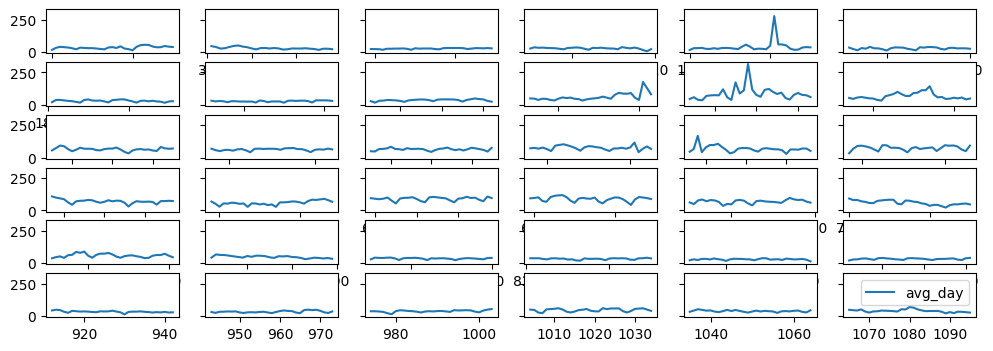

In [ ]:
ncols=6
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4), sharey=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
#     print(grouped['avg_day'].get_group(key))
    grouped['avg_day'].get_group(key).plot(ax=ax)

ax.legend()
plt.show()

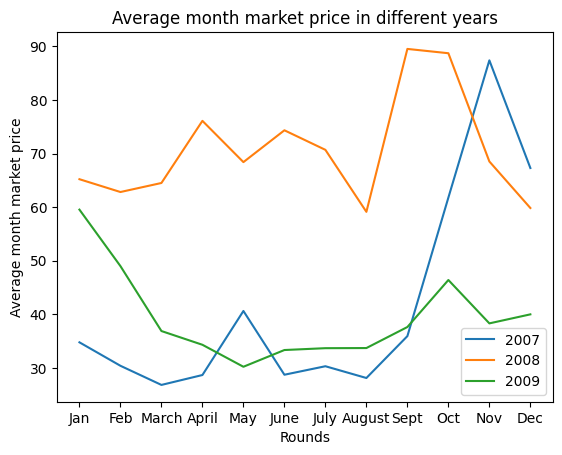

In [ ]:

    
year07 = l[:12]
year08 = l[12:24]
year09 = l[24:]

z = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'Sept', 'Oct', 'Nov', 'Dec']
plt.plot(z, year07)
plt.plot(z, year08)
plt.plot(z, year09)

plt.title('Average month market price in different years',    fontsize=12)
plt.ylabel('Average month market price')
plt.xlabel('Rounds', fontsize=10)
plt.legend(['2007', '2008', '2009'], loc='lower right', fontsize=10)

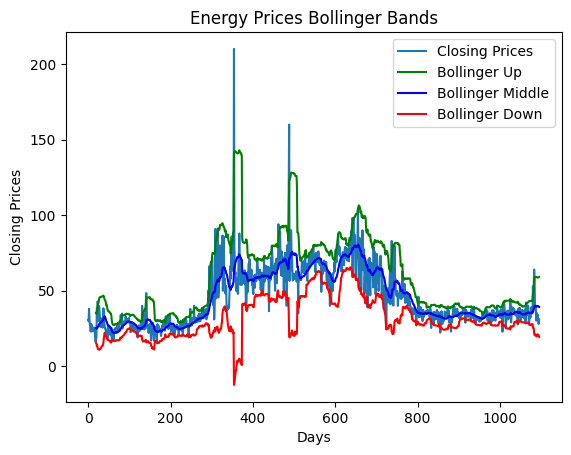

In [ ]:
closing_prices = train['Hour 24'] # now using only closing prices

def get_sma(prices, rate):
    return prices.rolling(rate).mean()

    
def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate) # Get SMA for 20 days
    std = prices.rolling(rate).std() # Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_middle = sma
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_middle, bollinger_down

bollinger_up, bollinger_middle, bollinger_down = get_bollinger_bands(closing_prices)

# Plot the data
plt.title('Energy Prices Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_middle, label='Bollinger Middle', c='b')
plt.plot(bollinger_down, label='Bollinger Down', c='r')
plt.legend()
plt.show()

In [ ]:
def get_ema(df, period_length:int):
    x = df.copy()
    
    # not sure if it should be adjusted or not
    x[f'{period_length}dayEWM'] = x['avg_day'].ewm(span=period_length, adjust=False).mean()
    x[f'{period_length}dayEWMadjust'] = x['avg_day'].ewm(span=period_length, adjust=True).mean()
    
    
    plt.plot(x[f'{period_length}dayEWM'], label=f'{period_length}-day EWM')
    # plt.plot(x['4dayEWMadjust'], label='4-day EWM adjusted')

    #add legend to plot
    plt.legend(loc=1)
    

([<matplotlib.lines.Line2D at 0x7fd55fc28b80>], None, None)

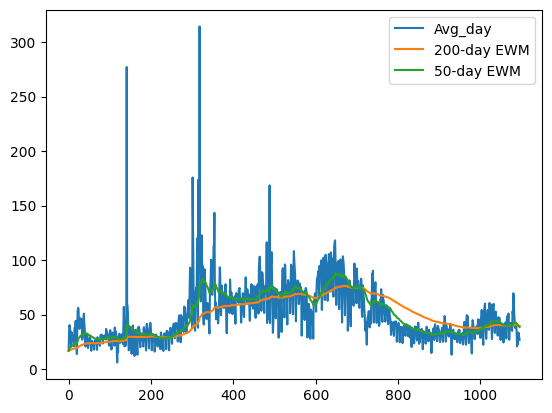

In [ ]:
plt.plot(train['avg_day'], label='Avg_day'), get_ema(train, 200), get_ema(train, 50)

In [ ]:
np.zeros(5).dtype

dtype('float64')